# Task 2b: Sign Detection with YOLOv12

**Student:** Thaina Helena De Oliveira Alves  
**Student ID:** 0150103A    
**Model:** YOLOv12


This notebook implements a YOLOv12 object detector to detect the shape of Maltese traffic signs. It covers:
1.  **Dataset Preparation**: Loading images and annotations.
2.  **Model Training**: Fine-tuning a pre-trained `YOLOv12` model to detect and classify circular, damaged, octagonal, square, or triangular shapes.
3.  **Evaluation**: Calculating F1-Scores.
4.  **Inference & Analytics**: Visualising and counting detections of sign shapes.

Mounting drive and changing directories:

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import os
os.listdir()

['.gitignore',
 'README.md',
 'merged_input.json',
 'Assignment Material',
 'results',
 'runs',
 'yolov8m.pt',
 'models',
 'yolo11n.pt',
 'yolo12m.pt',
 'yolo26n.pt']

In [3]:
os.chdir("drive/MyDrive/Computer-Vision-2-main")

In [ ]:
# --- Environment & Imports ---
from __future__ import annotations
import importlib, subprocess, sys, json, os
from ultralytics import YOLO
import glob
import matplotlib.pyplot as plt
import yaml
import cv2
def ensure_package(pkg: str, import_name: str | None = None, pip_name: str | None = None):
    try:
        return importlib.import_module(import_name or pkg)
    except ImportError:
        pip_target = pip_name or pkg
        print(f"Installing missing package: {pip_target}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_target], stdout=subprocess.DEVNULL)
        return importlib.import_module(import_name or pkg)

torch = ensure_package("torch")
yolov8 = ensure_package("ultralytics")

torch.manual_seed(42)
print("Environment ready: all dependencies installed and imported.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Environment ready: all dependencies installed and imported.


## 1. Dataset Preparation
The dataset for the YOLOv11 model is prepared automatically by the data.yaml file in the YOLO_COCO_sign_shape dataset.

In [11]:
# Path to the data.yaml file
DATA_YAML = "/content/drive/MyDrive/Computer-Vision-2-main/Assignment Material/YOLO_COCO_sign_shape/data.yaml"


In [12]:
print(os.path.exists(DATA_YAML))


True


## 2. Model Fine-Tuning & Training
We load the YOLOv12 model, also pre-trained on the large-scale COCO dataset, and use Ultralytics' **tune** method to find the optimal hyperparameters for our model.

We then train the model until it stops improving. The model is configured to train for 100 epochs, but to stop training early in case no improvements are seen after 20 consecutive epochs.

In [ ]:
# Loads a pre-trained YOLOv12 model
model = YOLO('yolo12m.pt')

# Fine-tunes the model to find the best hyperparameters
model.tune(
    data=DATA_YAML,
    epochs=15,
    imgsz=640,
    batch=8,
    patience=5,
    iterations=15,
    optimizer="AdamW",
    project="models",
    name="yolov12_tuning",
    resume=True
)


Tuner: Initialized Tuner instance with 'tune_dir=/content/drive/.shortcut-targets-by-id/1iLGa_2VPt40nMuzukUEFEnvkrjz2seIO/Computer-Vision-2-main/models/yolov12_tuning'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/15 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'cutmix': 0.0, 'copy_paste': 0.0, 'close_mosaic': 10}
Saved /content/drive/.shortcut-targets-by-id/1iLGa_2VPt40nMuzukUEFEnvkrjz2seIO/Computer-Vision-2-main/models/yolov12_tuning/tune_scatter_plots.png
Saved /content/drive/.shortcut-targets-by-id/1iLGa_2VPt40nMuzukUEFEnvkrjz2seIO/Computer-Vision-2-main/models/yolov12_tuning/tune_fitness.png

In [13]:
# Path to the hyperparameters.yaml file
BEST_HYP = "/content/drive/MyDrive/Computer-Vision-2-main/models/yolov12_tuning/best_hyperparameters.yaml"
print(os.path.exists(BEST_HYP))

# opening yaml file and saving contents to a dict
with open(BEST_HYP, "r") as f:
    best_hyp = yaml.safe_load(f)

# turning certain keys of best_hyp into int datatype as that is what is expected by YOLO
INT_KEYS = {
    "epochs",
    "batch",
    "patience",
    "warmup_epochs",
    "close_mosaic"
}
for k in INT_KEYS:
    if k in best_hyp:
        best_hyp[k] = int(best_hyp[k])



True


In [20]:
# display the hyperparameters we will be training the model with
print(best_hyp)

{'lr0': 0.00802, 'lrf': 0.02641, 'momentum': 0.93421, 'weight_decay': 0.0, 'warmup_epochs': 3, 'warmup_momentum': 0.95, 'box': 7.20515, 'cls': 0.43266, 'dfl': 1.80445, 'hsv_h': 0.01423, 'hsv_s': 0.87705, 'hsv_v': 0.57758, 'degrees': 0.00645, 'translate': 0.10698, 'scale': 0.4845, 'shear': 0.00244, 'perspective': 0.0, 'flipud': 0.01286, 'fliplr': 0.40855, 'bgr': 0.00018, 'mosaic': 0.94858, 'mixup': 0.00376, 'cutmix': 0.00337, 'copy_paste': 6e-05, 'close_mosaic': 9}


In [21]:
# Loads a pre-trained YOLOv12 model
model = YOLO('yolo12m.pt')

# Trains the model and gets the training results
results = model.train(
    data=DATA_YAML,
    epochs=100,
    patience=20,
    imgsz=640,
    batch=8,
    **best_hyp,
    project='models',
    name='yolov12_final',
    exist_ok=True
)


Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.00018, box=7.20515, cache=False, cfg=None, classes=None, close_mosaic=9, cls=0.43266, compile=False, conf=None, copy_paste=6e-05, copy_paste_mode=flip, cos_lr=False, cutmix=0.00337, data=/content/drive/MyDrive/Computer-Vision-2-main/Assignment Material/YOLO_COCO_sign_shape/data.yaml, degrees=0.00645, deterministic=True, device=None, dfl=1.80445, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.40855, flipud=0.01286, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01423, hsv_s=0.87705, hsv_v=0.57758, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00802, lrf=0.02641, mask_ratio=4, max_det=300, mixup=0.00376, mode=train, model=yolo12m.pt, momentum=0.93421, mosaic=0.94858, multi_scale=0.0, name=yolov

## 3. Evaluating on Test Set
This section loads the best YOLOv12 model and evaluates its performance on the test set, generating metrics and plots to assess detection accuracy.

In [23]:
#reloading the best model
best_model = YOLO('models/yolov12_final/weights/best.pt')

# evaluate the best trained model on the test set and generate plots
test_results = best_model.val(
    data=DATA_YAML,
    split="test",
    plots=True
)


Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 169 layers, 20,108,767 parameters, 0 gradients, 67.1 GFLOPs
val: Fast image access ✅ (ping: 8.6±18.6 ms, read: 234.7±132.6 MB/s, size: 1528.4 KB)
val: Scanning /content/drive/MyDrive/Computer-Vision-2-main/Assignment Material/YOLO_COCO_sign_shape/labels/test.cache... 116 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 116/116 34.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.6s/it 13.0s
                   all        116        130       0.66      0.702       0.69      0.576
              Circular         52         57      0.697      0.772      0.787      0.635
               Damaged          8          8       0.25      0.375      0.163      0.114
             Octagonal         33         33      0.861      0.939      0.935      0.823
                Square         14         15      0.706        0

## 4. Analytics and Visualisation
This section provides functions and tools to visualise the results and analytics of the YOLOv8 model.

In [ ]:
# YOLOv12's best model's outputs
test_dir = 'runs/detect/val_yolov12'

# Function to display images from a folder in a grid format
def show_images_from_folder(
    folder,
    title,
    patterns,
    cols = 2,
    img_size=5
):

    image_paths = []
    for pattern in patterns:
        image_paths.extend(glob.glob(os.path.join(folder, pattern)))
    image_paths.sort()

    if not image_paths:
        print(f'No images found in {folder}')
        return

    n = len(image_paths)
    rows = (n + cols - 1) // cols # Logic to get number of rows needed

    # Figure size scales with rows
    fig_width = cols * img_size
    fig_height = rows * img_size

    # Create subplots
    fig, axes = plt.subplots(
        rows, cols,
        figsize=(fig_width, fig_height),
        constrained_layout=True
    )

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    for ax, img_path in zip(axes, image_paths):
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_aspect('equal')
        ax.axis('off')

    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close(fig)


***Evaluation PLots***
Displays key evaluation plots such as the confusion matrix, precision-recall curves and F1-curves to help interpret the model's performance.


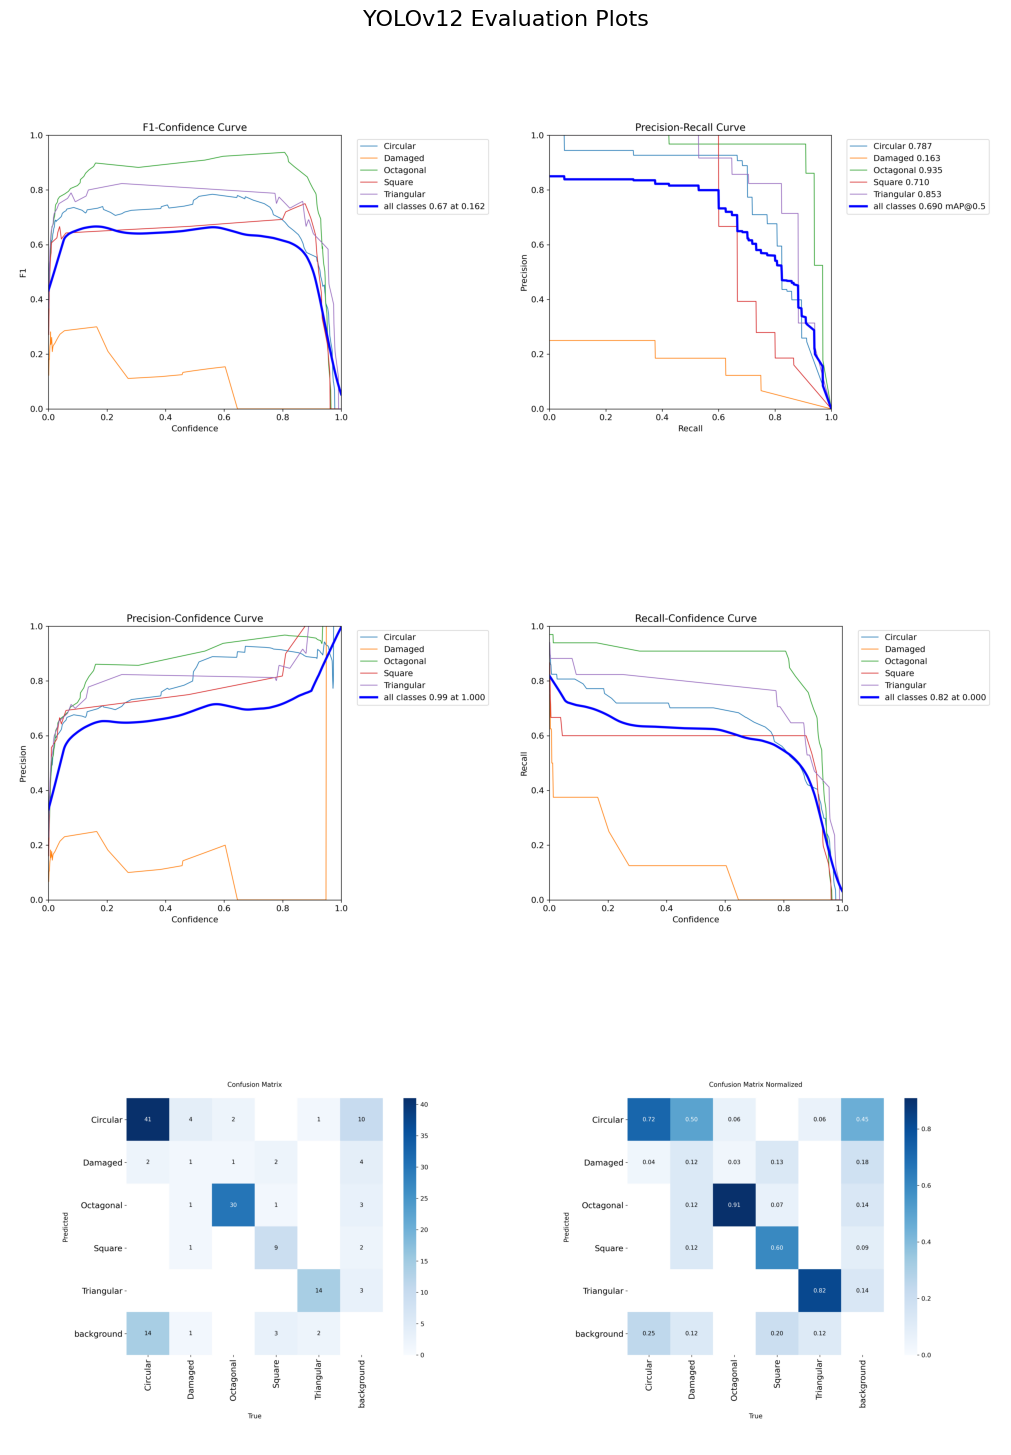

In [ ]:
plot_patterns = (
    'confusion_matrix*.png',
    '*curve*.png',
)

show_images_from_folder(
    test_dir,
    title='YOLOv12 Evaluation Plots',
    patterns=plot_patterns
)


***Labels and Predictions***

Shows sample images with predicted bounding boxes and labels, allowing for a visual comparison between model predictions and ground truth.

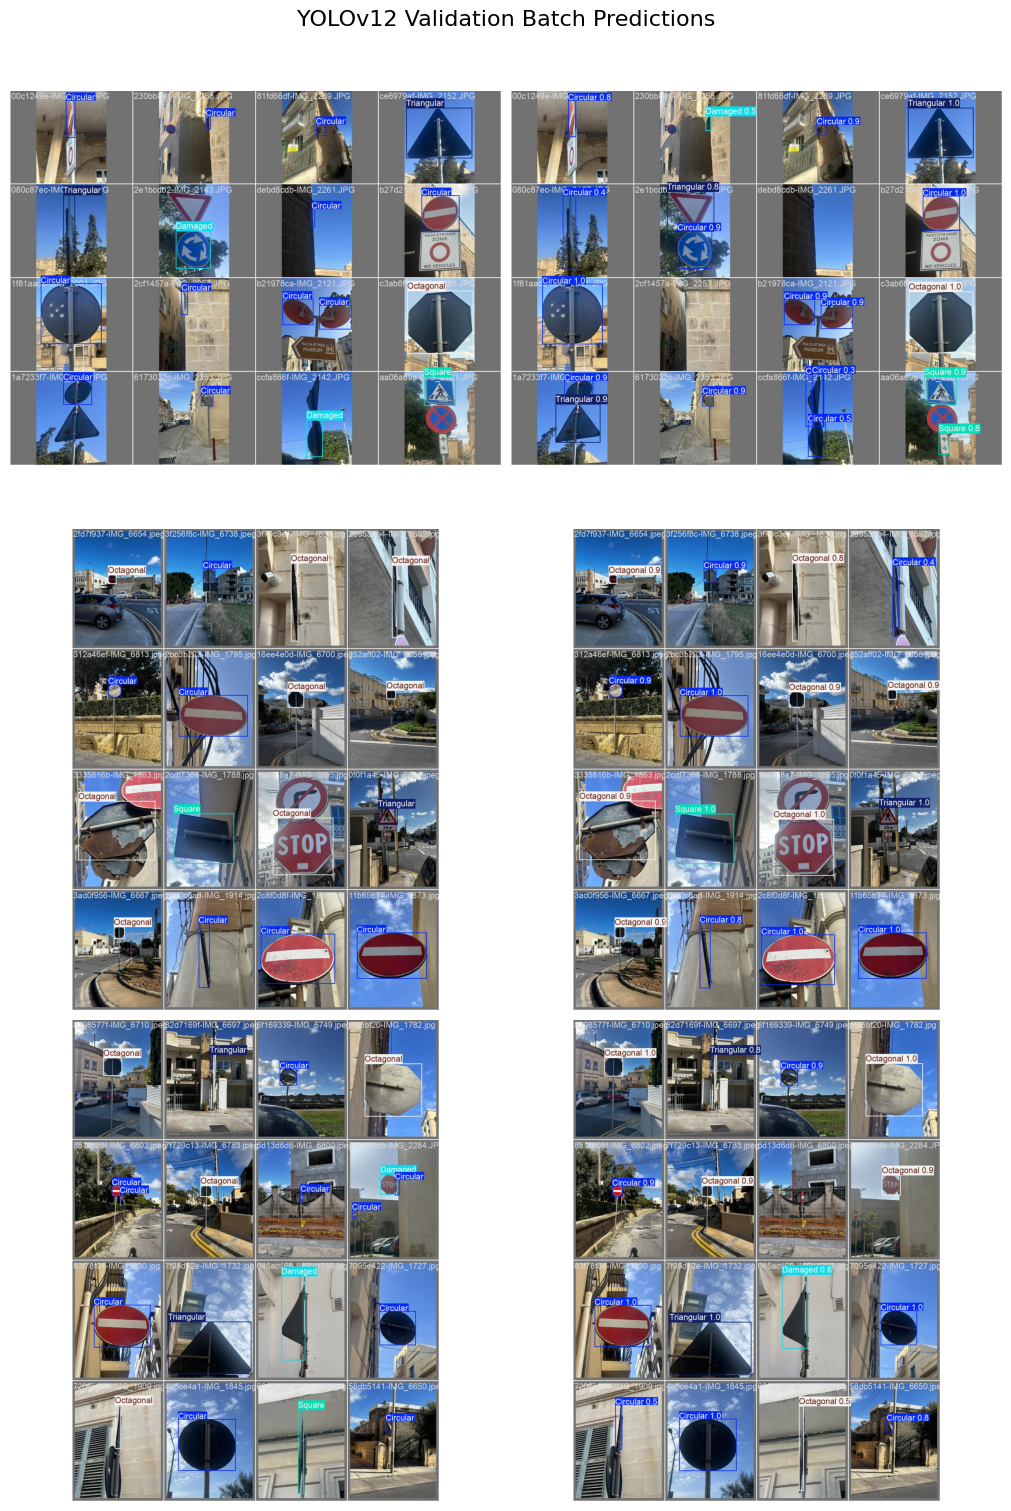

In [ ]:
test_batch_patterns = ('val_batch*.jpg', 'val_batch*.png')

show_images_from_folder(
    test_dir,
    title='YOLOv12 Validation Batch Predictions',
    patterns=test_batch_patterns
)


In [7]:
best_model = YOLO('models/yolov12_final/weights/best.pt')

# predicts class of each image in the test set. The output wsas used for visual inspection of Damaged predictions and discussed in the report.
best_model.predict(
    source="/content/drive/MyDrive/Computer-Vision-2-main/Assignment Material/YOLO_COCO_sign_shape/images/test",
    imgsz=640,
    conf=0.25,
    save=True,
    project="runs",
    name="yolov12_preds"
)


image 1/116 /content/drive/MyDrive/Computer-Vision-2-main/Assignment Material/YOLO_COCO_sign_shape/images/test/00c1249e-IMG_2176.JPG: 640x480 1 Circular, 1284.1ms
image 2/116 /content/drive/MyDrive/Computer-Vision-2-main/Assignment Material/YOLO_COCO_sign_shape/images/test/02412b93-20251215_145520.jpg: 640x384 1 Octagonal, 1713.8ms
image 3/116 /content/drive/MyDrive/Computer-Vision-2-main/Assignment Material/YOLO_COCO_sign_shape/images/test/075bd81e-IMG_6670.jpeg: 640x480 2 Circulars, 1081.3ms
image 4/116 /content/drive/MyDrive/Computer-Vision-2-main/Assignment Material/YOLO_COCO_sign_shape/images/test/080c87ec-IMG_2157.JPG: 640x480 (no detections), 1000.7ms
image 5/116 /content/drive/MyDrive/Computer-Vision-2-main/Assignment Material/YOLO_COCO_sign_shape/images/test/0e02f146-IMG_1889.jpg: 640x480 1 Circular, 1158.9ms
image 6/116 /content/drive/MyDrive/Computer-Vision-2-main/Assignment Material/YOLO_COCO_sign_shape/images/test/0f0f1a45-IMG_6690.jpeg: 640x480 1 Triangular, 1667.1ms
ima

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Circular', 1: 'Damaged', 2: 'Octagonal', 3: 'Square', 4: 'Triangular'}
 obb: None
 orig_img: array([[[171, 172, 170],
         [169, 170, 168],
         [168, 169, 167],
         ...,
         [161, 164, 162],
         [160, 163, 161],
         [159, 162, 160]],
 
        [[171, 172, 170],
         [170, 171, 169],
         [168, 169, 167],
         ...,
         [161, 164, 162],
         [162, 165, 163],
         [162, 165, 163]],
 
        [[172, 173, 171],
         [170, 171, 169],
         [168, 169, 167],
         ...,
         [161, 164, 162],
         [163, 166, 164],
         [165, 168, 166]],
 
        ...,
 
        [[203, 238, 248],
         [203, 238, 248],
         [203, 238, 248],
         ...,
         [164, 169, 160],
         [165, 170, 161],
         [166, 171, 162]],
 
        [[203, 238, 248],
         [202, 237, 24

In [ ]:
print("\nVisualizing Sample Predictions:")

# Gets list of validation images
test_image_paths = sorted(glob.glob('Assignment Material/YOLO_COCO_sign_shape/images/test/*'))

# Loops and predicts each input image
for i, img_path in enumerate(test_image_paths):

    results = best_model(img_path, verbose=False)

    # Visualises image
    for result in results:

        # Gets number of detections and their chosen attribute (class name)
        num_signs = len(result.boxes) if hasattr(result, 'boxes') else 0
        if hasattr(result, 'names') and hasattr(result, 'boxes'):
            class_ids = result.boxes.cls.cpu().numpy().astype(int)
            attributes = [result.names[cid] for cid in class_ids]
        else:
            attributes = []
        print(f"Image {i}: {num_signs} signs detected. Attributes: {attributes}")

        img_array = result.plot() 
            
        plt.figure(figsize=(8, 8))
        # Converts BGR to RGB for matplotlib
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.title(f"Image {i} Prediction")
        plt.axis('off')
        plt.show()